In [19]:
import stan
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import math
import pprint
# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
# df = pd.read_csv('final_voting_data_long.csv')
df = pd.read_csv('eurovision_merged_covariates_03Feb.csv').drop('Unnamed: 0', axis=1)
df['has_border'] = df['has_border'].replace(np.nan,0)


In [3]:
def format_votes(x):
  if x == 12.:
    return 10
  elif x == 10.:
    return 9
  return int(x)
df['indexed_votes'] = df['Votes'].apply(format_votes) + 1
score_options = df['indexed_votes'].unique().tolist()
score_options.sort()
print(score_options)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


{'0': 8859,
 '1': 656,
 '10': 680,
 '12': 715,
 '2': 632,
 '3': 652,
 '4': 635,
 '5': 651,
 '6': 652,
 '7': 663,
 '8': 657}


/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/ipykernel_73335/672210069.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


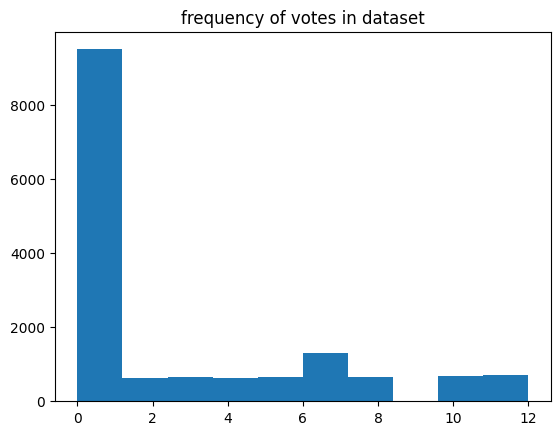

In [20]:
# crop data based on vote to make dataset unbalanced w.r.t vote frequency
# removed half of all votes, except votes of 3
fig,ax = plt.subplots()
ax.hist(df['Votes'])
ax.set_title('frequency of votes in dataset')
fig.show()
for i in range(13):
    if i == 9 or i == 11:
        continue
    print(f'{df['Votes'].loc[df['Votes'] == float(i)].count()}')

pprint.pprint(vote_counts)




In [50]:
df['male'] = [1 if gender=='male' else 0 for gender in df['Gender']]
df['female'] = [1 if gender=='female' else 0 for gender in df['Gender']]

In [63]:
model = """
data {
  int<lower=2> S;
  int<lower=0> N;
  int<lower=1> D;
  array[N] int<lower=1, upper=S> y;
  array[N] row_vector[D] x;

  //int<lower=0> N_new; // number of predictions
  //array[N_new] row_vector[D] x_new; // covariates for predictions
}
parameters {
  vector[D] beta;
  ordered[S-1] lambda;
}
model {
  vector[N] mu;
  beta ~ normal(0, 10000);
  lambda ~ normal(0, 3.2);
  for (n in 1:N) {
    mu[n] = x[n] * beta;
    y[n] ~ ordered_logistic(mu[n], lambda);
  }
}
generated quantities {
  vector[N] y_hat;
  for (n in 1:N) {
    y_hat[n] = ordered_logistic_rng(x[n] * beta, lambda);
  }

  // out of sample predictions (scores we expet to observe for new data)
  //vector[N_new] y_pred;
  //for (n in 1:N_new)
  //    y_pred[n] = ordered_logistic_rng(x_new[n] * beta, lambda);
}
"""

In [73]:
# test/train split
train_fraction = 0.8
n_train = math.floor(train_fraction * df.shape[0])

In [74]:
# build x matrix
x = df.loc[:,['Own','Other','male','female','has_border','prop_emigrants','comps_since_last_win']].values
x_test = x[n_train:]
x = x[:n_train]
print(x)
print(x.shape)

[[0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  6.53211624e-05 4.30000000e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.42507011e-04 1.20000000e+01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.69788776e-04 4.30000000e+01]
 ...
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  1.74604680e-04 6.00000000e+01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  6.76156003e-04 1.30000000e+01]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.25097607e-04 6.00000000e+01]]
(12361, 7)


In [75]:
data = {
    'S': 11,
    'N': n_train,
    'D': x.shape[1],
    'y': df['indexed_votes'][:n_train].values,
    'x': x,
    # 'N_new': df.shape[0]-n_train,
    # 'x_new': x_test
}

In [76]:
posterior = stan.build(model, data=data)
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=2500, num_thin=5)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_o0brvrky/model_w5xwew5x.stan', line 18, column 19: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (400/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15%

In [77]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    # predictions="y_pred", 
    posterior_model=posterior)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>],
       [<Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n6'}>]], dtype=object)

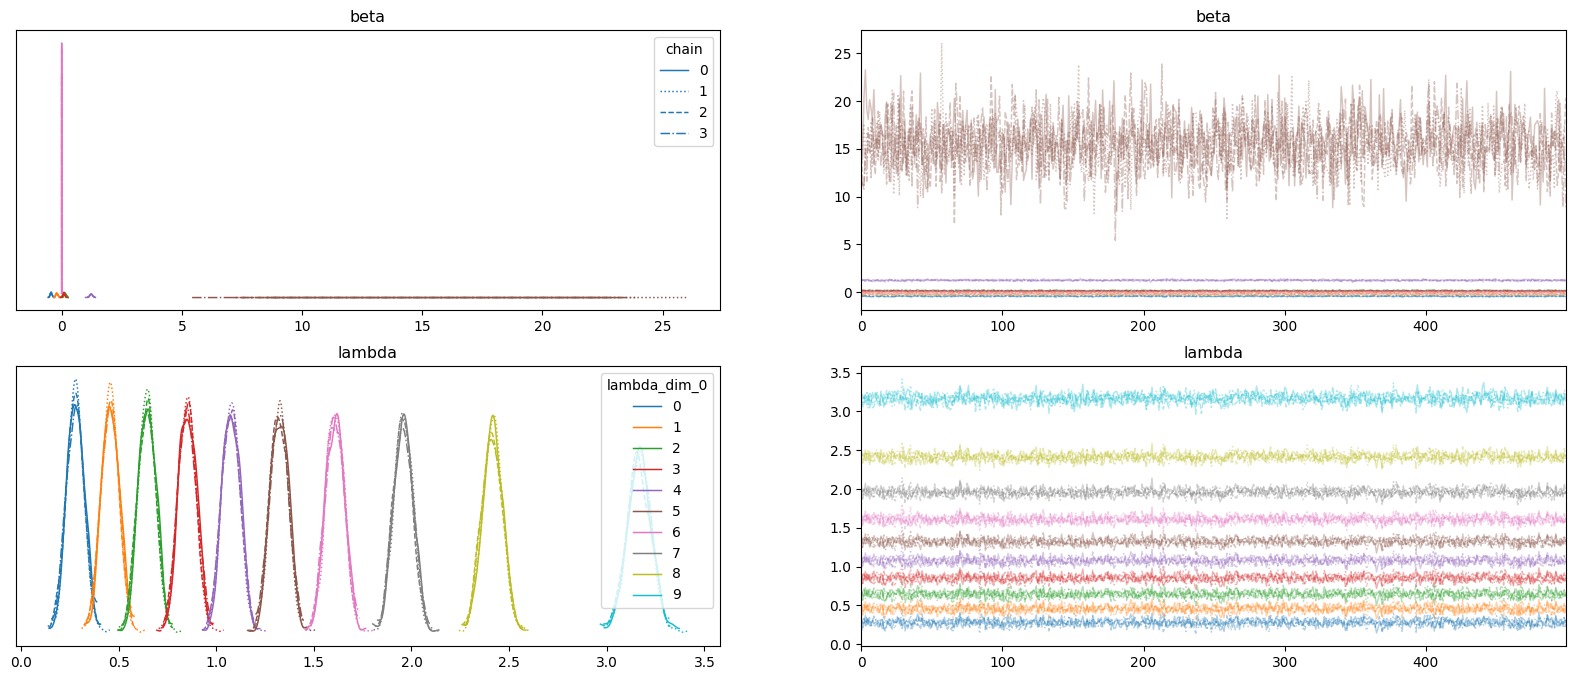

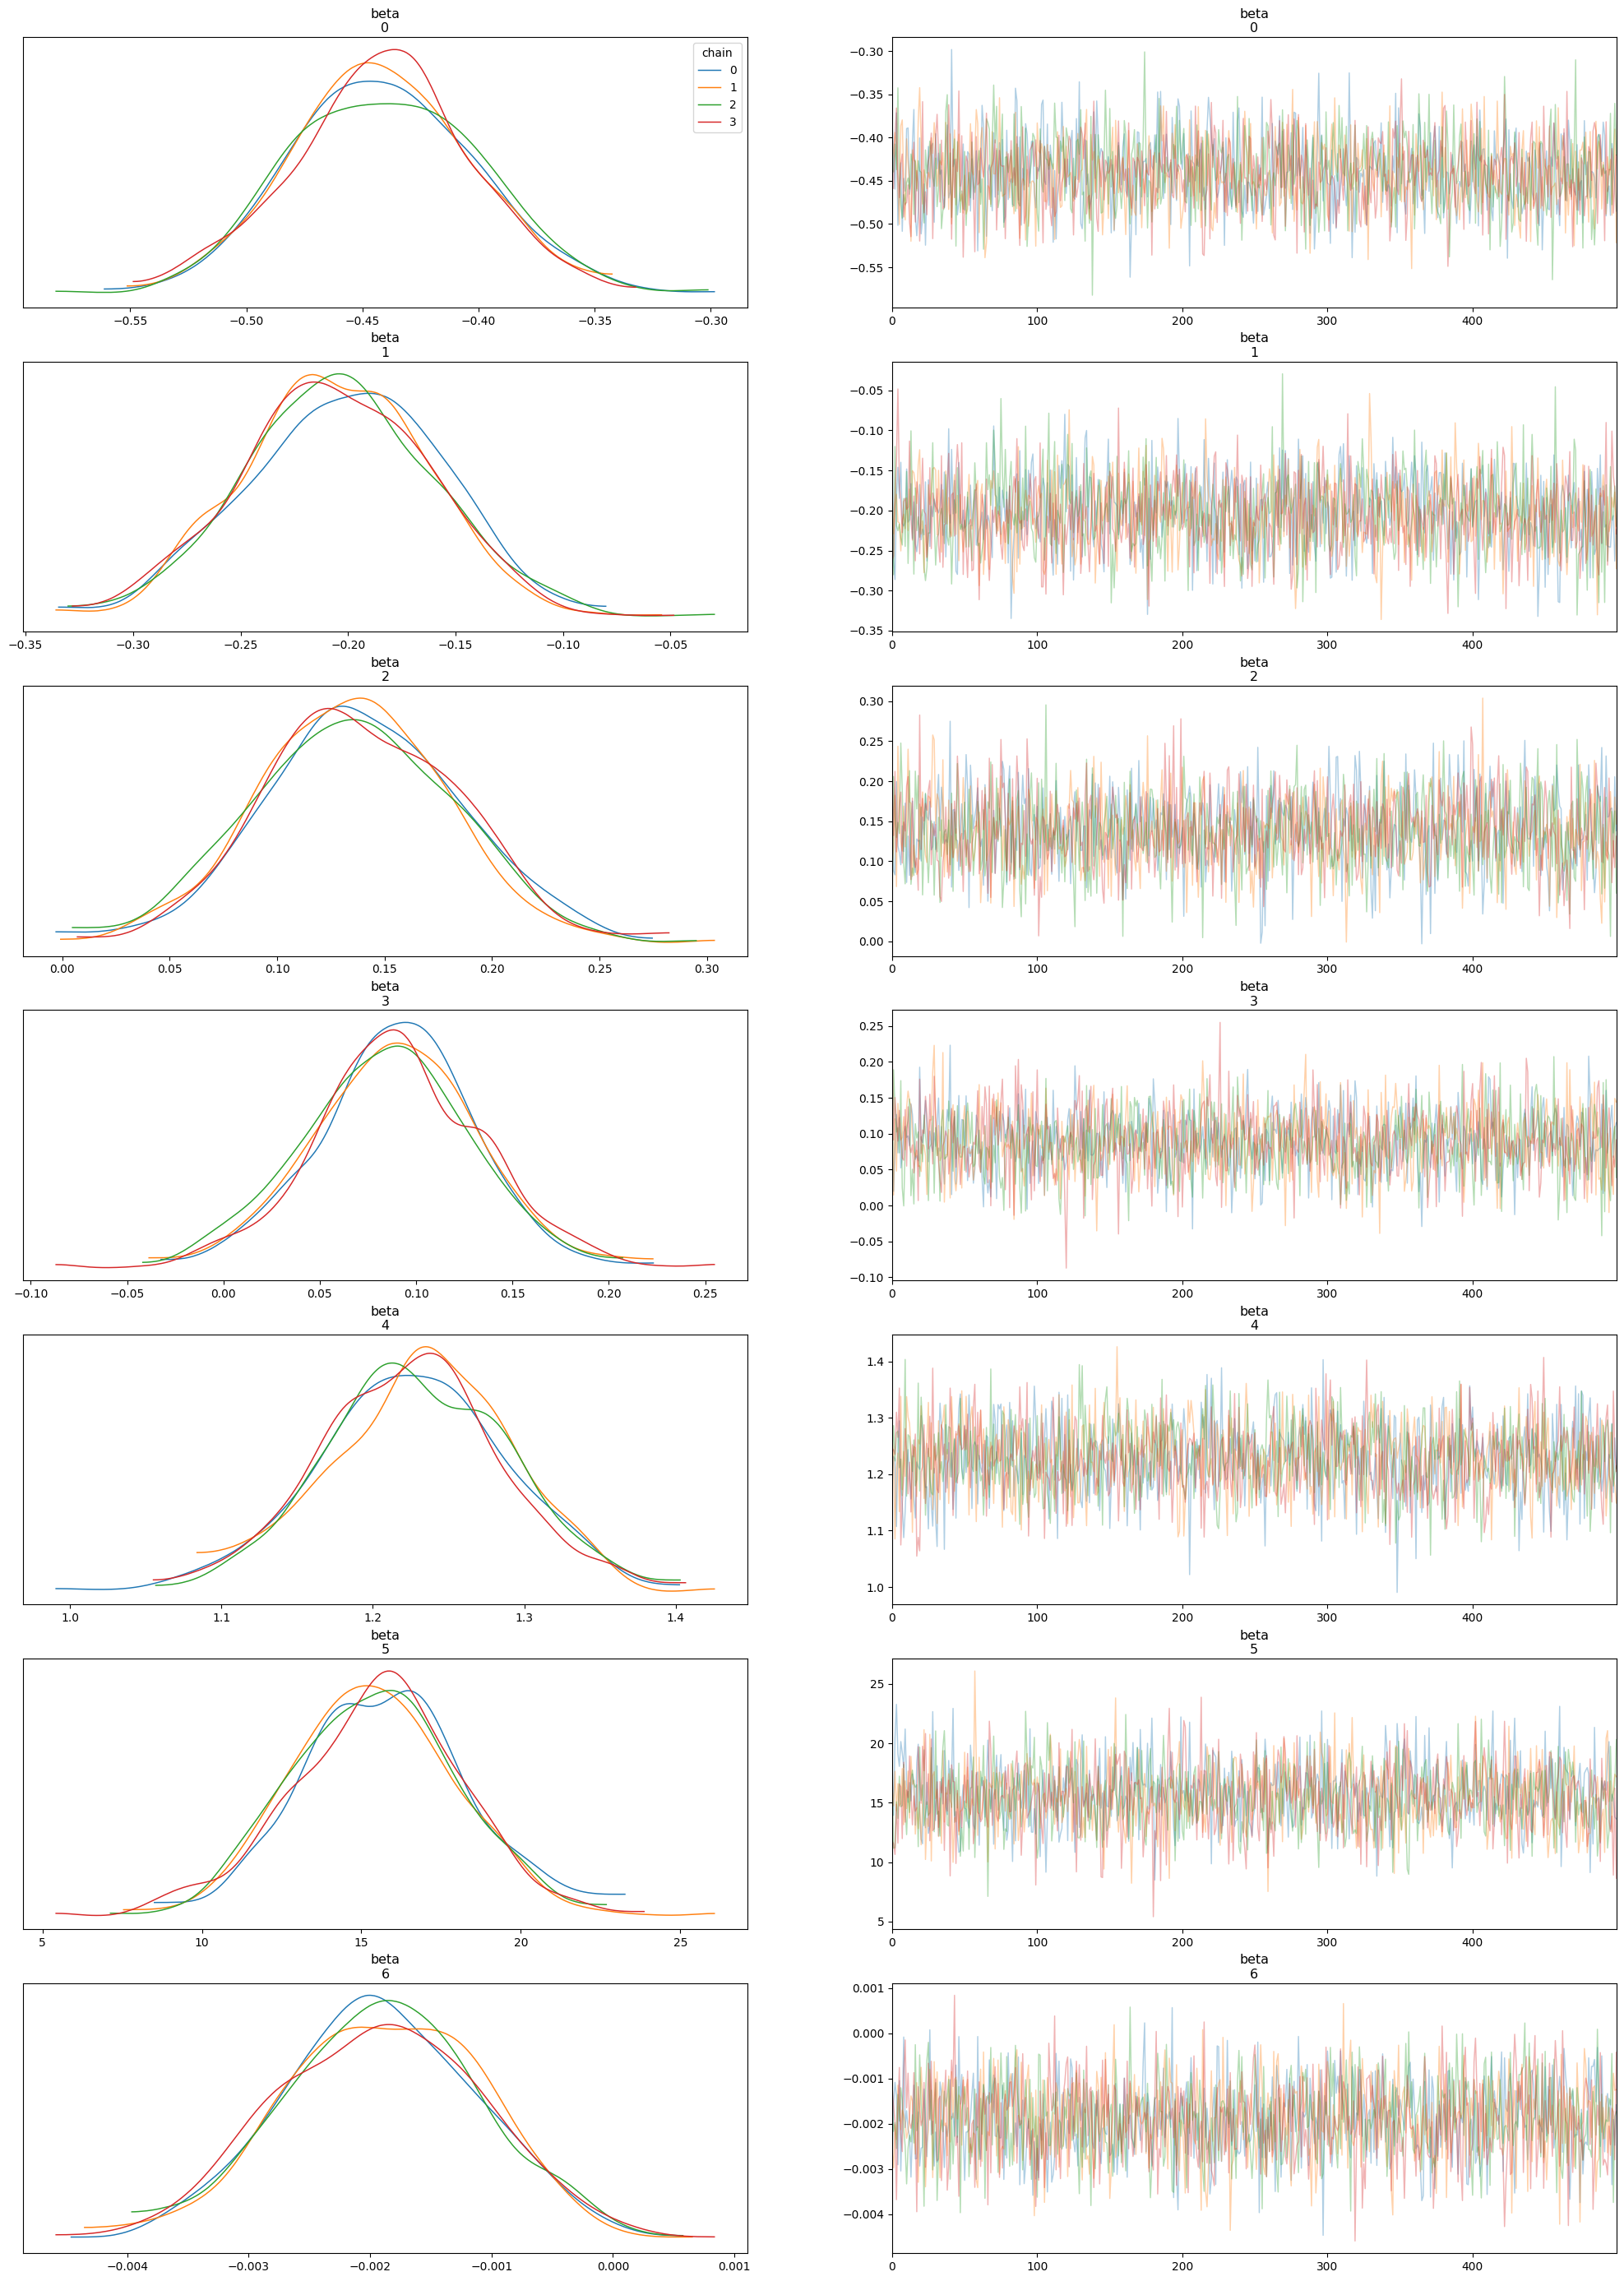

In [82]:
az.plot_trace(az_fit, ["beta","lambda"], figsize=(20,8), legend=True)
az.plot_trace(az_fit, ["beta"], figsize=(25,35), legend=True, compact=False)